I did the VAR model instead of a multivariate ARIMA model. The results are in VAR model.ipynb file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dateutil import parser
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
station_id=5001
# read the .csv file into a DataFrame
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
df=pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['acquisition_timestamp'], utc=True)


# rearrange the data
new_data = df.pivot_table(index='timestamp', columns='parameter_type', values='value').reset_index()

# ensure 'acquisition_timestamp' is in datetime format
new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])

new_data.set_index('timestamp', inplace=True)


# fill NaN values in the row with the values of next row with non NaN values
new_data = new_data.fillna(method='bfill')


print('Shape of data :', new_data.shape)
print('index type :',type(new_data.index))
new_data.head()


Shape of data : (271508, 7)
index type : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


parameter_type,AIR_PRESSURE,AMBIENT_TEMPERATURE,RAIN_INTENSITY,RELATIVE_HUMIDITY,SOLAR_RADIATION_INTENSITY,WIND_DIRECTION,WIND_SPEED
timestamp,,,,,,,
2020-10-13 10:20:00+00:00,952.8,7.4,0.0,63.9,285.6,294.0,2.45
2020-10-13 10:25:00+00:00,952.8,7.5,0.0,62.5,262.0,294.0,2.45
2020-10-13 10:30:00+00:00,952.8,7.4,0.0,61.9,270.9,282.0,2.81
2020-10-13 10:35:00+00:00,952.8,7.5,0.0,62.2,307.4,301.0,3.28
2020-10-13 10:40:00+00:00,952.8,7.6,0.0,62.2,342.0,289.0,1.27


In [10]:
# count the NaN values
nan_count = new_data.isna().sum()
print(nan_count)
# NO nan values

parameter_type
AIR_PRESSURE                 0
AMBIENT_TEMPERATURE          0
RAIN_INTENSITY               0
RELATIVE_HUMIDITY            0
SOLAR_RADIATION_INTENSITY    0
WIND_DIRECTION               0
WIND_SPEED                   0
dtype: int64


In [11]:
# check for missing measurements (skipped times)
complete_range = pd.date_range(start=new_data.index.min(), end=new_data.index.max(), freq='5T')
missing_timestamps = complete_range.difference(new_data.index)
print(f"missing time stamps ={len(missing_timestamps)}")
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
print(f"df complete range = {len(df_complete_range)}")

missing time stamps =5112
df complete range = 276620


In [12]:
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# merge all the measurements with all the time steps. missing measurment will be NaN values for now
new_data_incomplete = df_complete_range.merge(new_data, left_index=True, right_index=True, how='left')
print(new_data_incomplete.isna().sum()) # okay

# missing measurements are filled with the next available measurement
new_data_all = new_data_incomplete.bfill()

# fill NaN values in the row with the values of next row with non-NaN values
new_data_all = new_data_all.fillna(method='bfill')

#print(new_data_all)
print(new_data_all.isna().sum()) # okay

str(new_data_all.index.dtype) # okay

AIR_PRESSURE                 5112
AMBIENT_TEMPERATURE          5112
RAIN_INTENSITY               5112
RELATIVE_HUMIDITY            5112
SOLAR_RADIATION_INTENSITY    5112
WIND_DIRECTION               5112
WIND_SPEED                   5112
dtype: int64
AIR_PRESSURE                 0
AMBIENT_TEMPERATURE          0
RAIN_INTENSITY               0
RELATIVE_HUMIDITY            0
SOLAR_RADIATION_INTENSITY    0
WIND_DIRECTION               0
WIND_SPEED                   0
dtype: int64


'datetime64[ns, UTC]'

In [13]:
# resampled the data hourly with mean.
new_data_all_resampled=new_data_all.resample('1H').mean()
new_data_all_resampled.head()

,AIR_PRESSURE,AMBIENT_TEMPERATURE,RAIN_INTENSITY,RELATIVE_HUMIDITY,SOLAR_RADIATION_INTENSITY,WIND_DIRECTION,WIND_SPEED
2020-10-13 10:00:00+00:00,952.762500,7.687500,0.0,61.675000,300.837500,293.625000,2.357500
2020-10-13 11:00:00+00:00,952.366667,8.958333,0.0,56.825000,258.341667,312.666667,1.675000
2020-10-13 12:00:00+00:00,951.783333,10.183333,0.0,48.391667,260.816667,270.833333,0.826667
2020-10-13 13:00:00+00:00,951.691667,10.716667,0.0,43.625000,161.950000,291.083333,0.460833
2020-10-13 14:00:00+00:00,951.508333,10.833333,0.0,44.483333,155.100000,280.416667,0.477500


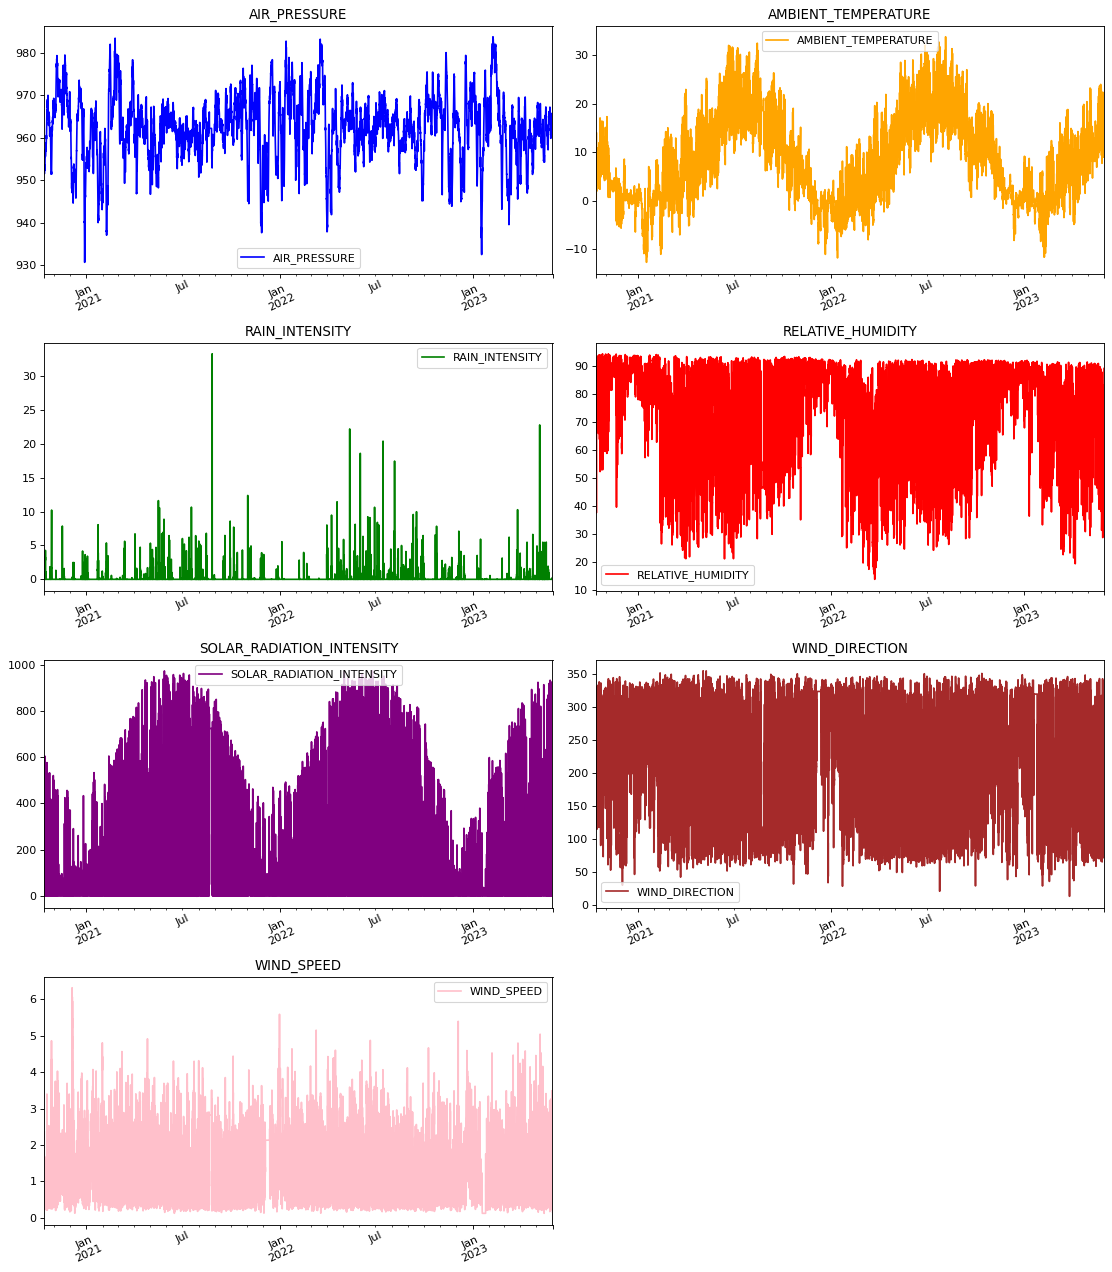

In [14]:
# plots

color_list=["blue","orange","green","red","purple","brown","pink"]

def Visualize(data):
    features=list(data.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)


   # create subplots with a flexible number of rows
    nrows = int(np.ceil(feature_size / 2))

    fig, axes = plt.subplots(
        nrows=nrows, ncols=2, 
        figsize=(14, nrows*4), dpi=80, facecolor='w', edgecolor='k'
    )
    
     # flatten the axes array for easy indexing
    if feature_size == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()


    # plot each feature
    for i in range(feature_size):
     key = features[i]
     c = color_list[i%(len(color_list))]
     t_data=data[key]
    
     ax=t_data.plot(
        ax=axes[i],
        color=c,
        title=key,
        rot=25,
     )
     ax.legend([key])
    

     # hide any unused subplots
    for j in range(feature_size, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()    

Visualize(new_data_all_resampled)    

In [15]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


In [4]:
import pmdarima as pm
import pandas as pd
import numpy as np
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np


from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [16]:
ts_decomposition = seasonal_decompose(x=new_data_all_resampled['AMBIENT_TEMPERATURE'], model='additive', period=24)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

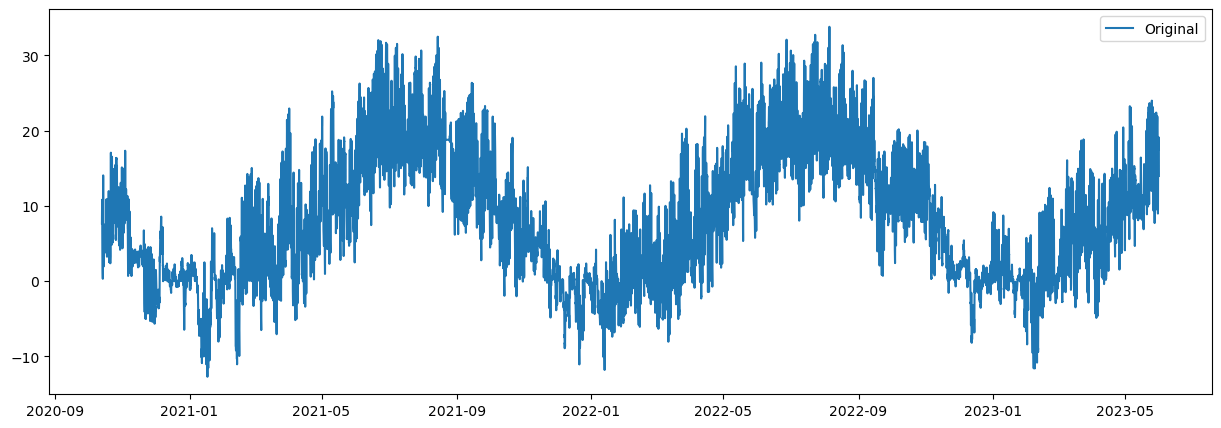

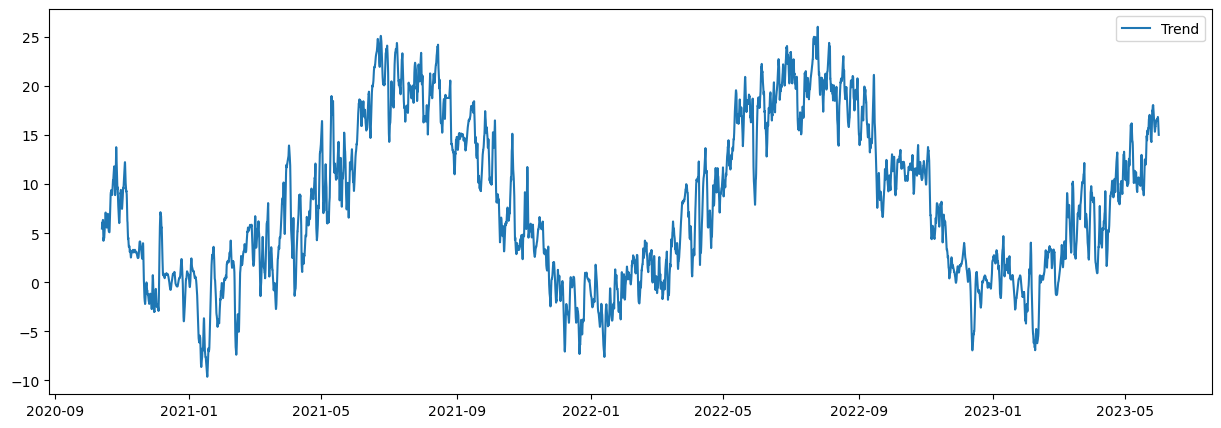

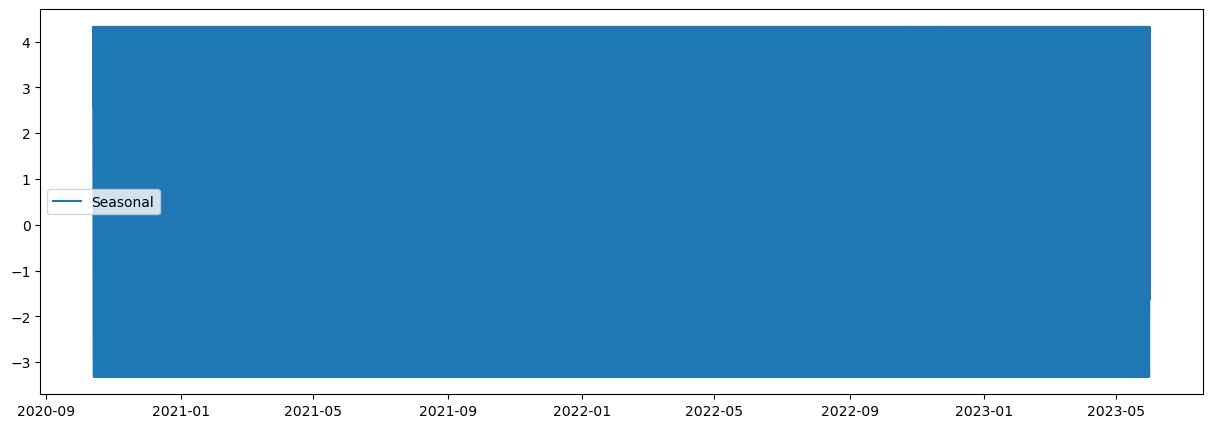

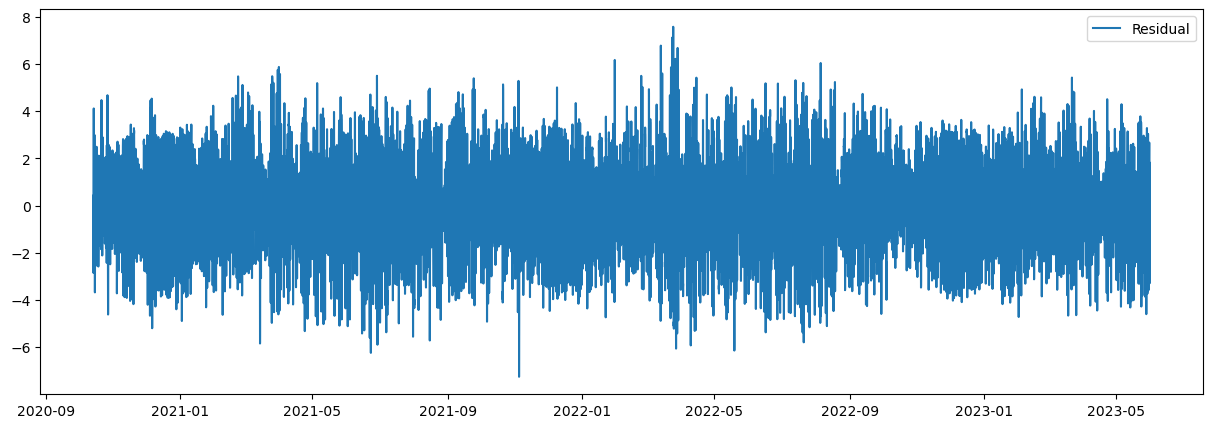

In [17]:
plt.figure(figsize=(15,5))
plt.plot(new_data_all_resampled['AMBIENT_TEMPERATURE'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

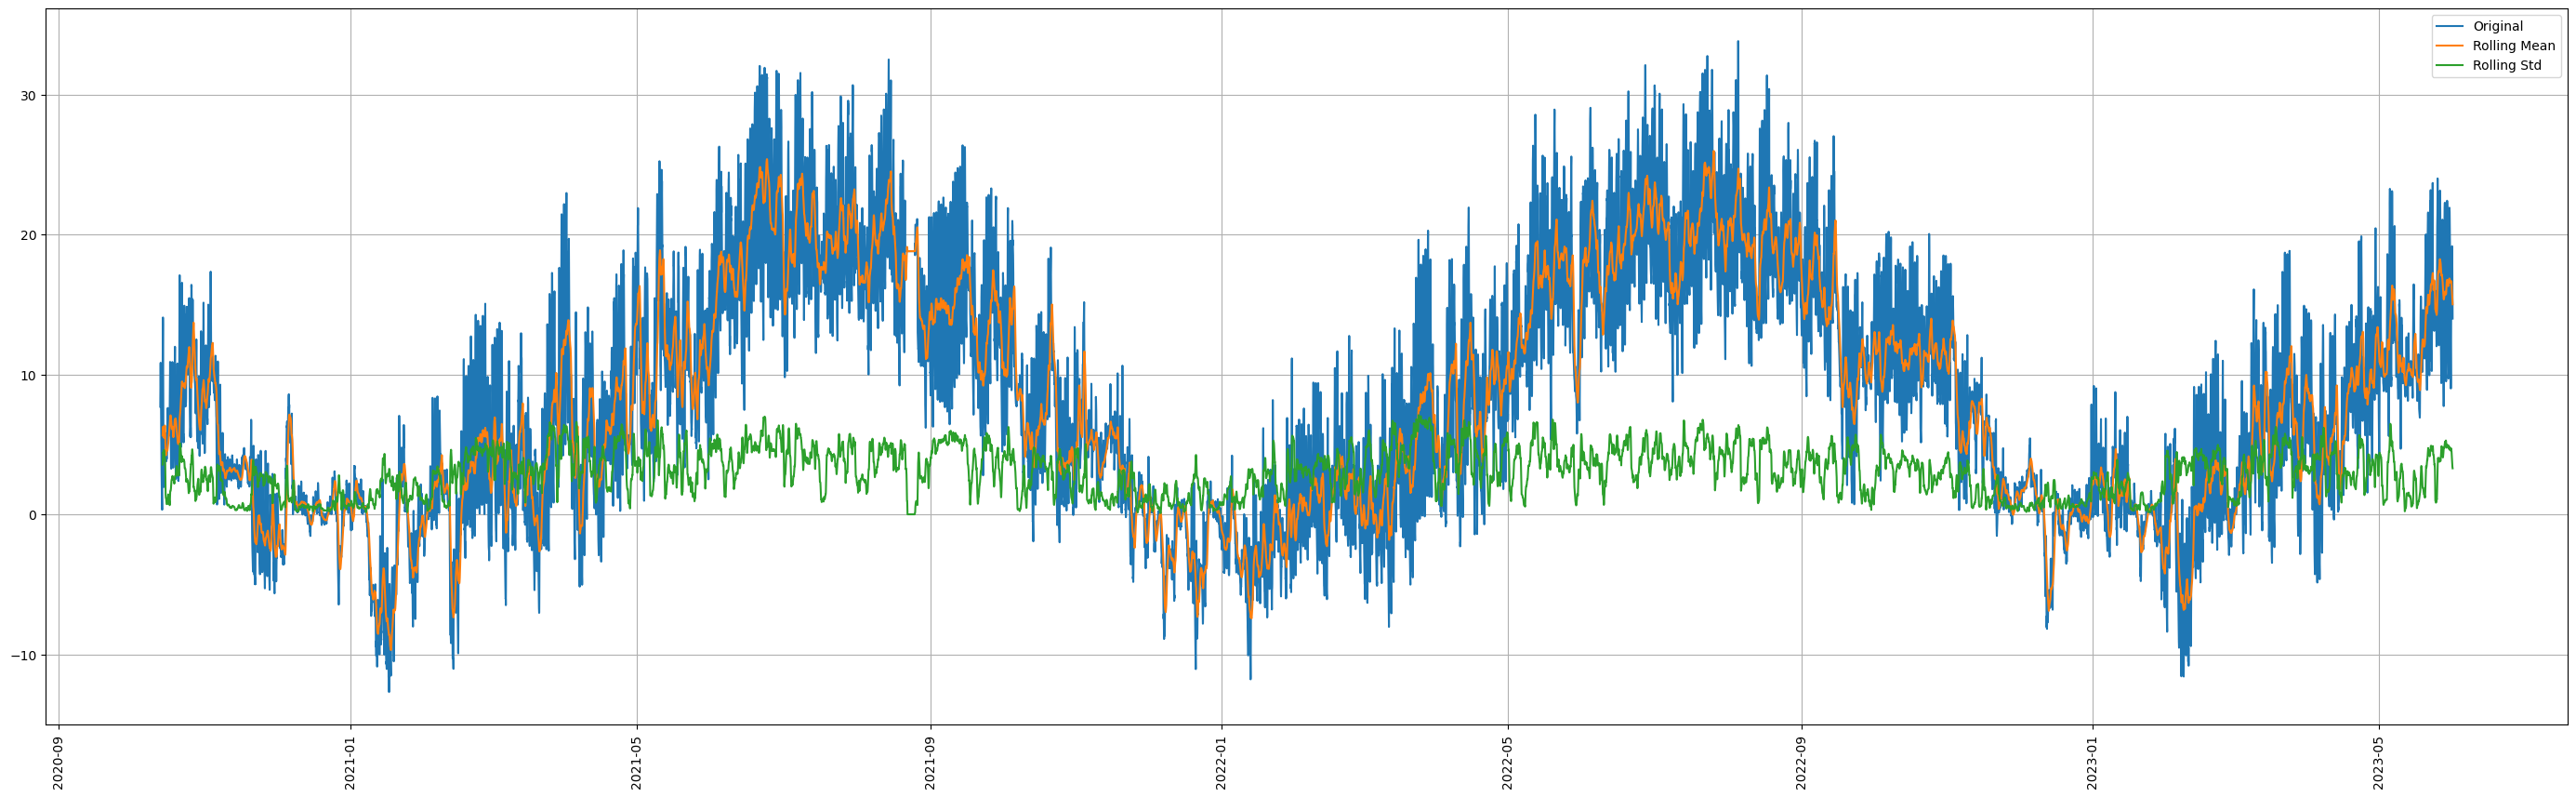

In [18]:
# rolling mean and standard deviation for ambient temperature

plt.figure(figsize=(35,10))
plt.grid()
plt.plot( new_data_all_resampled['AMBIENT_TEMPERATURE'], label='Original')
plt.plot( new_data_all_resampled['AMBIENT_TEMPERATURE'].rolling(window=25).mean(), label='Rolling Mean')
plt.plot(new_data_all_resampled['AMBIENT_TEMPERATURE'].rolling(window=25).std(), label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()


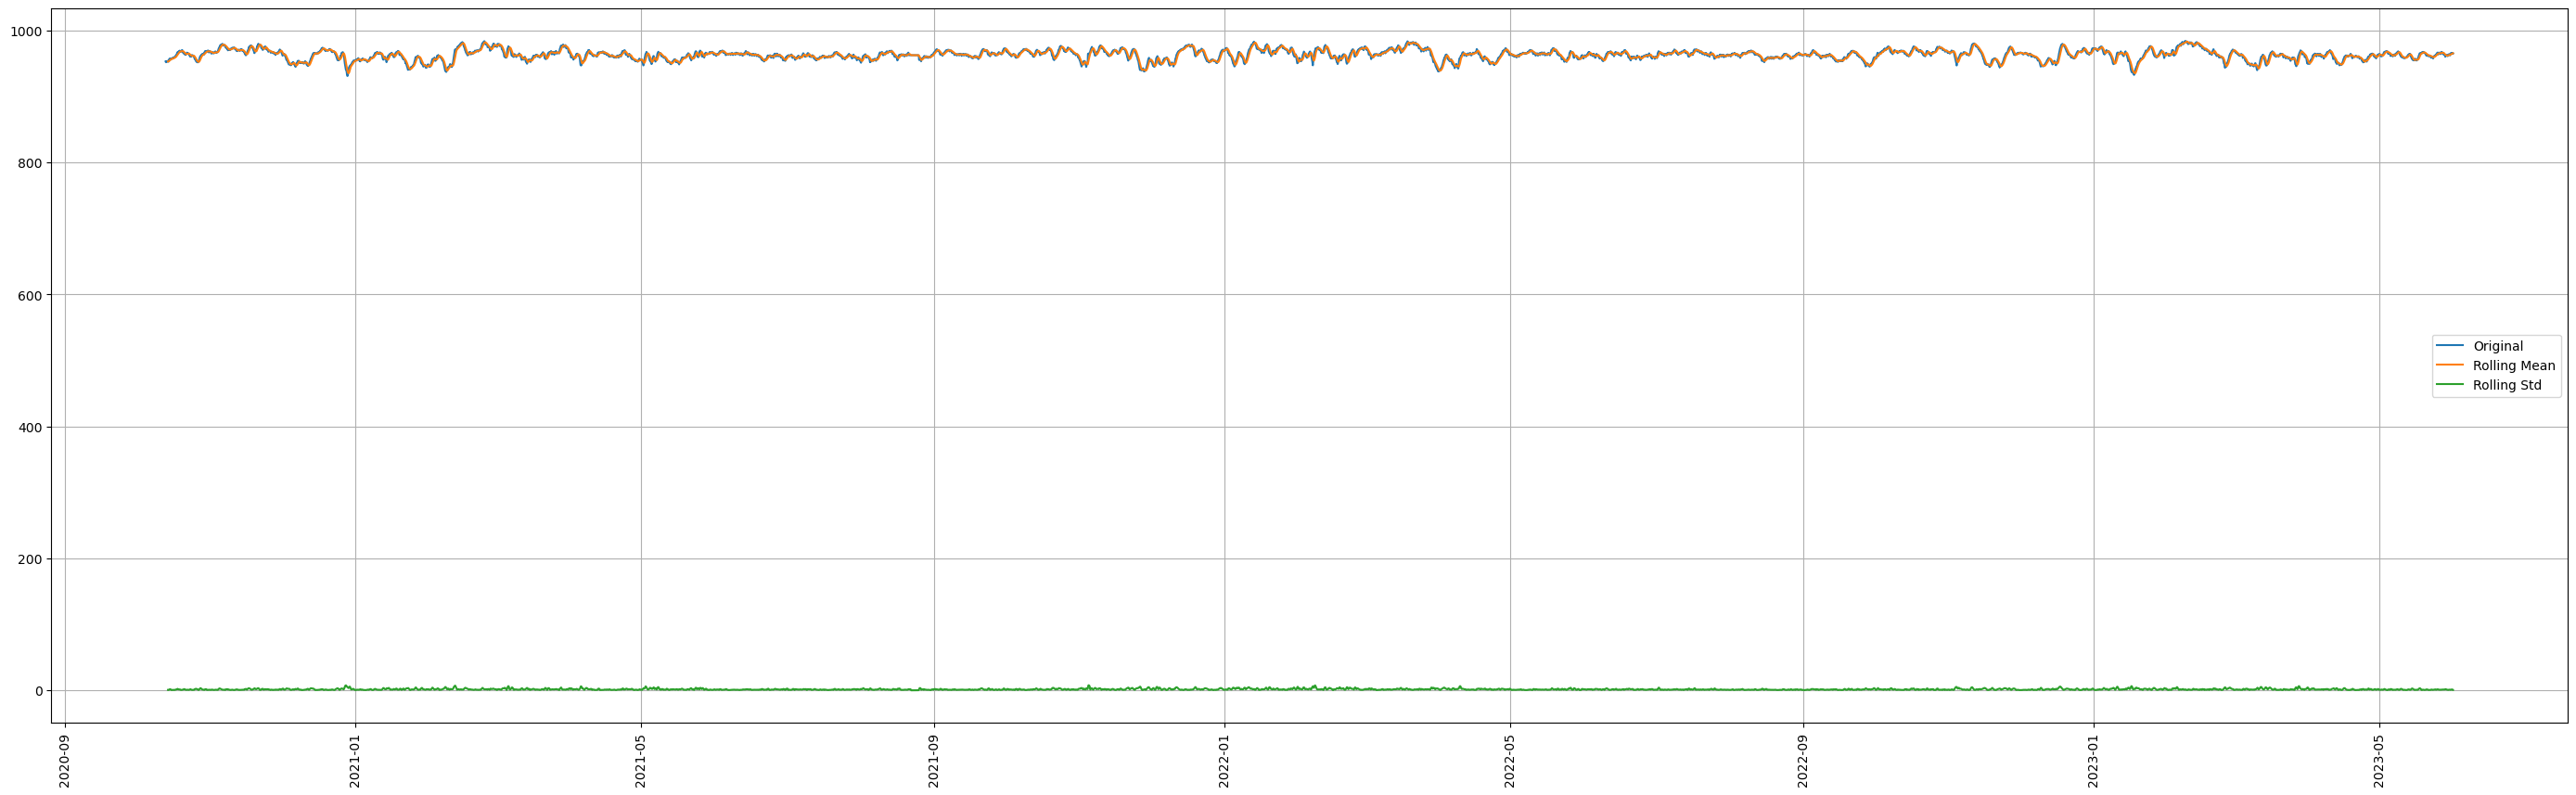

In [19]:
# rolling mean and standard deviation for air pressure

plt.figure(figsize=(35,10))
plt.grid()
plt.plot( new_data_all_resampled['AIR_PRESSURE'], label='Original')
plt.plot( new_data_all_resampled['AIR_PRESSURE'].rolling(window=25).mean(), label='Rolling Mean')
plt.plot(new_data_all_resampled['AIR_PRESSURE'].rolling(window=25).std(), label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

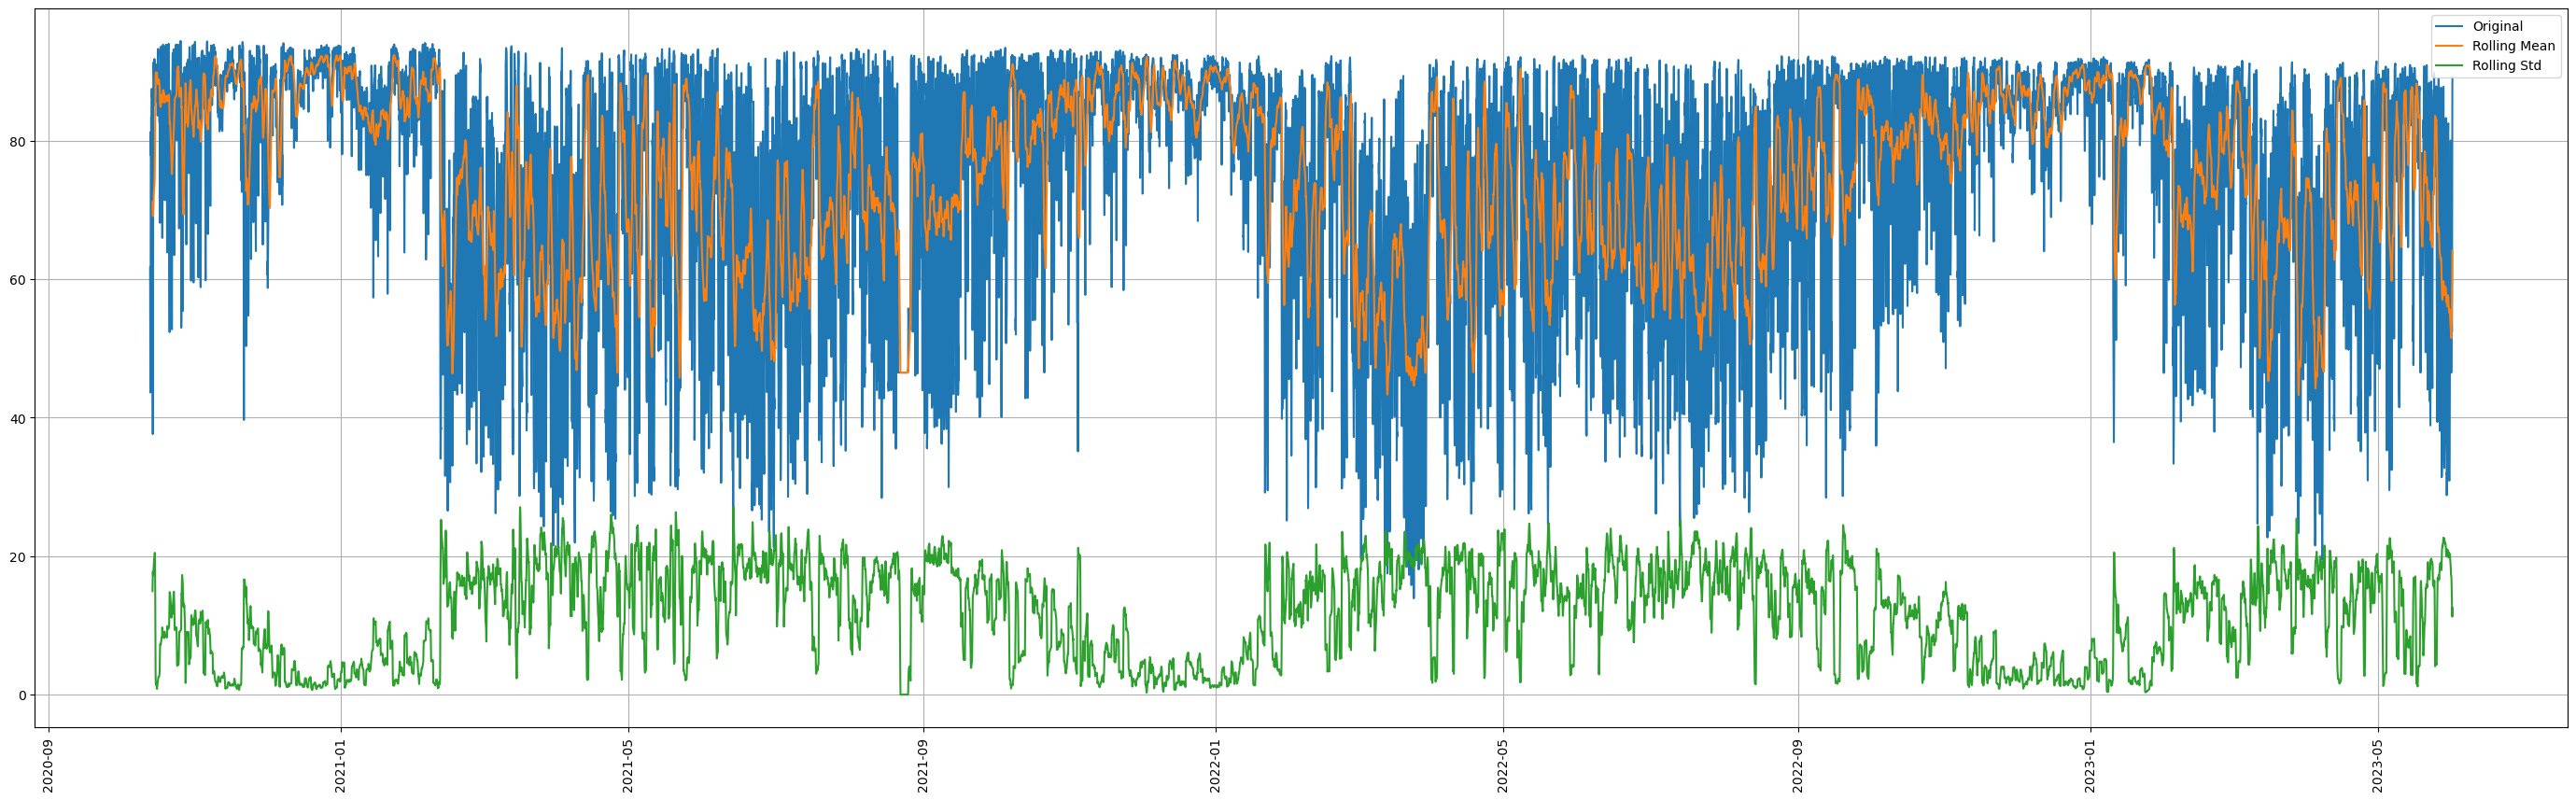

In [20]:
# rolling mean and standard deviation for relative humidity

plt.figure(figsize=(35,10))
plt.grid()
plt.plot( new_data_all_resampled['RELATIVE_HUMIDITY'], label='Original')
plt.plot( new_data_all_resampled['RELATIVE_HUMIDITY'].rolling(window=25).mean(), label='Rolling Mean')
plt.plot(new_data_all_resampled['RELATIVE_HUMIDITY'].rolling(window=25).std(), label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

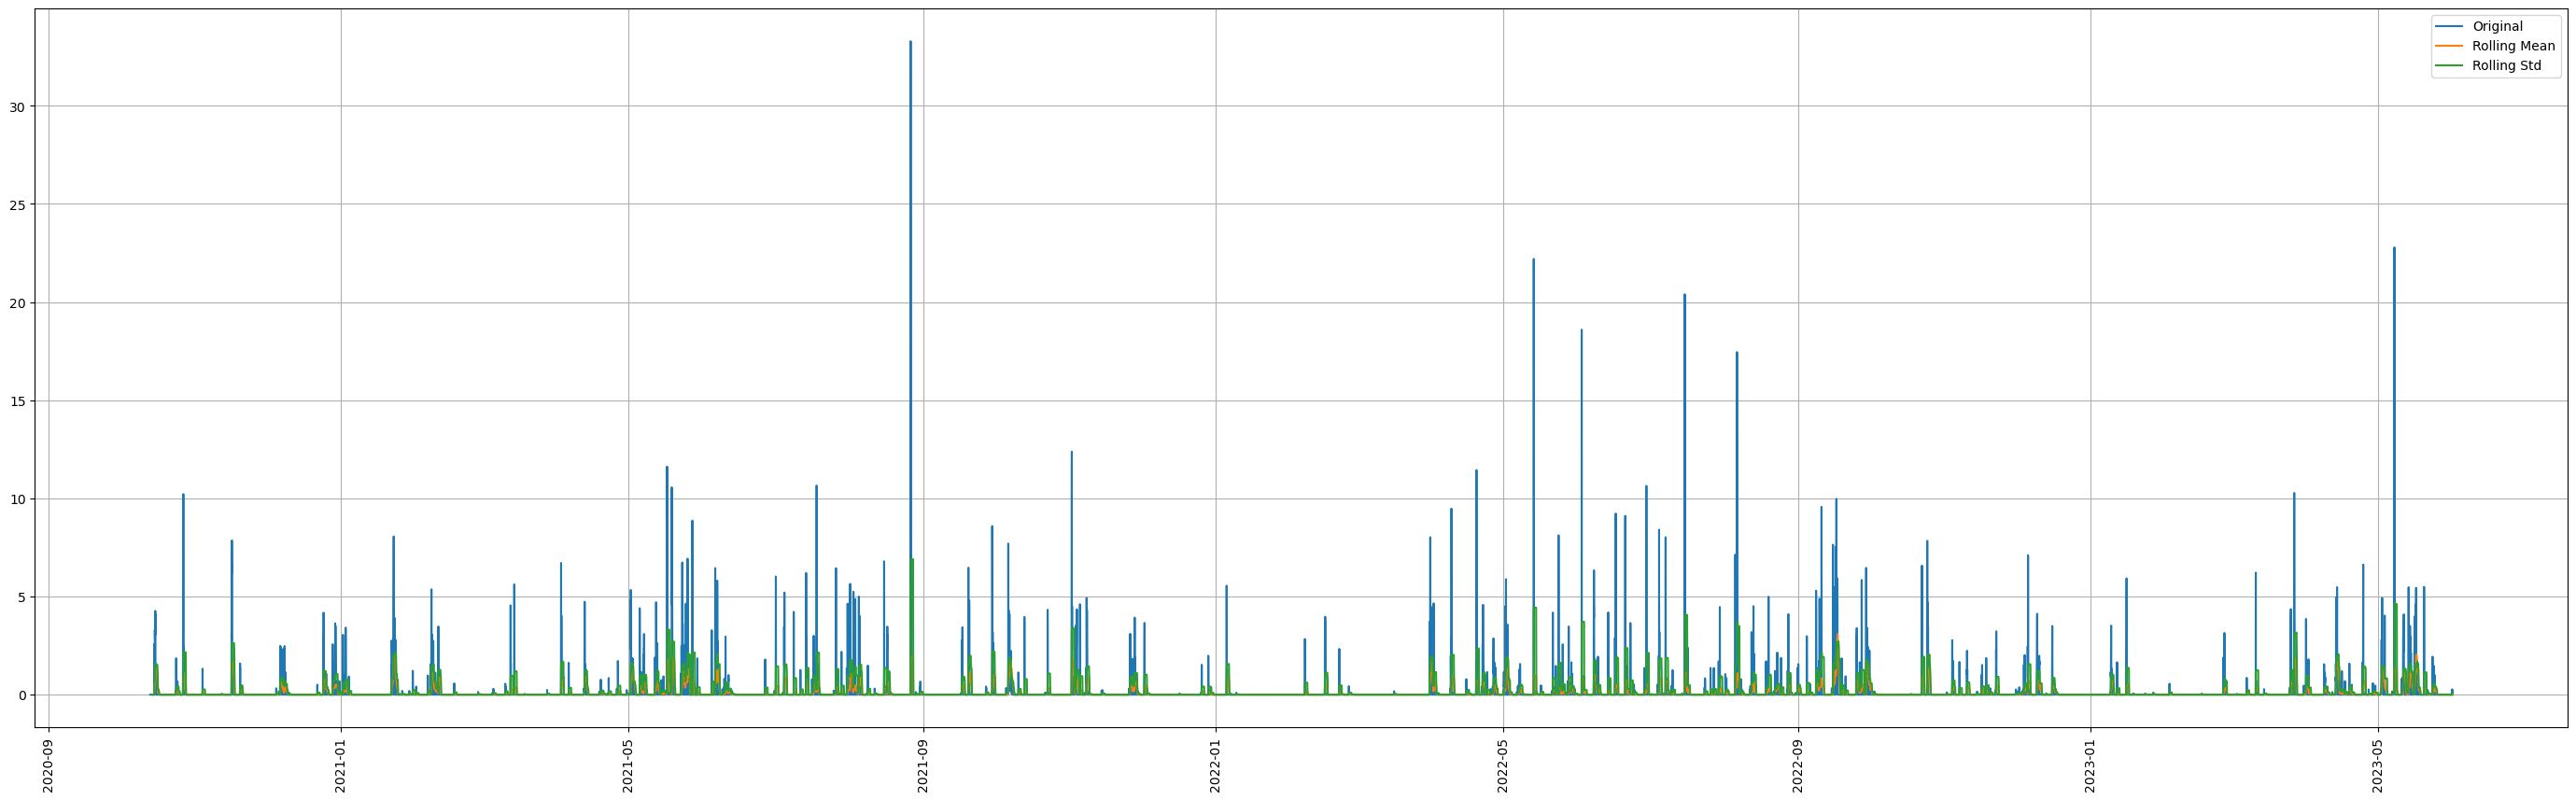

In [21]:
# rolling mean and standard deviation for rain intensity

plt.figure(figsize=(35,10))
plt.grid()
plt.plot( new_data_all_resampled['RAIN_INTENSITY'], label='Original')
plt.plot( new_data_all_resampled['RAIN_INTENSITY'].rolling(window=25).mean(), label='Rolling Mean')
plt.plot(new_data_all_resampled['RAIN_INTENSITY'].rolling(window=25).std(), label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [23]:
#Stationarity check

from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):
    

    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [24]:
# ADF Test on each column
for name, column in new_data_all_resampled.items():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AIR_PRESSURE" 
    -----------------------------------------------
ADF Statistic: -12.645121
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "AMBIENT_TEMPERATURE" 
    -----------------------------------------------
ADF Statistic: -3.973137
p-value: 0.001558
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "RAIN_INTENSITY" 
    -----------------------------------------------
ADF Statistic: -41.532225
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "RELATIVE_HUMIDITY" 
    -----------------------------------------------
ADF Statistic: -9.509234
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "SOLAR_RADIATION_INTENSITY" 
    -----------------------------------------------
ADF Statist

In [25]:
# split data sets

train=new_data_all_resampled[:int(0.5*(len(new_data_all_resampled)))]
test=new_data_all_resampled[int(0.5*(len(new_data_all_resampled))):]


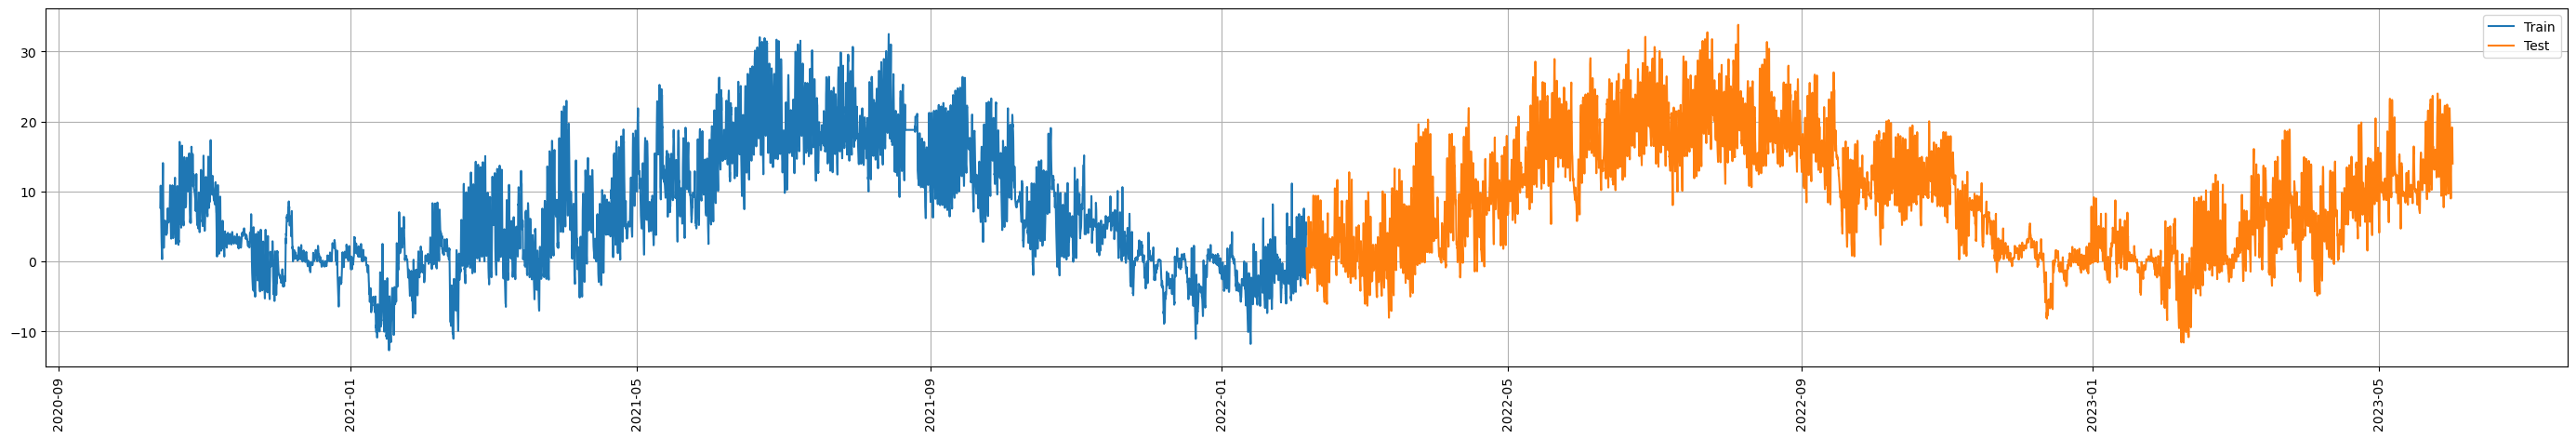

In [26]:
#Plotting
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(train['AMBIENT_TEMPERATURE'], label='Train')
plt.plot( test['AMBIENT_TEMPERATURE'], label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [21]:
# DONT RUN THIS EVERY TIME (77min)
# model

# fit an auto_arima model
arima = pm.auto_arima(train['AMBIENT_TEMPERATURE'],X=train.drop(columns=['AMBIENT_TEMPERATURE']), d=2,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf')

# print out summary information on the fit
print(arima.summary())
print(arima.params)



Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=143.57 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=13218.411, Time=16.44 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=12921.916, Time=8.40 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=12685.131, Time=28.61 sec
 ARIMA(0,2,1)(0,0,0)[4]             : AIC=12699.915, Time=17.28 sec
 ARIMA(0,2,1)(1,0,1)[4]             : AIC=12671.918, Time=34.27 sec
 ARIMA(0,2,1)(1,0,0)[4]             : AIC=12687.453, Time=27.38 sec
 ARIMA(0,2,1)(2,0,1)[4]             : AIC=12641.267, Time=47.19 sec
 ARIMA(0,2,1)(2,0,0)[4]             : AIC=12657.600, Time=23.10 sec
 ARIMA(0,2,1)(2,0,2)[4]             : AIC=12660.451, Time=67.21 sec
 ARIMA(0,2,1)(1,0,2)[4]             : AIC=12691.078, Time=14.57 sec
 ARIMA(0,2,0)(2,0,1)[4]             : AIC=13210.100, Time=18.50 sec
 ARIMA(1,2,1)(2,0,1)[4]             : AIC=inf, Time=225.68 sec
 ARIMA(0,2,2)(2,0,1)[4]             : AIC=11564.382, Time=260.86 sec
 ARIMA(0,2,2)(1

In [27]:
# plot test and pred

number_periods = len(test)
pred = arima.predict(n_periods=number_periods, X=test.drop(columns=['AMBIENT_TEMPERATURE']), alpha=0.05)

# Convert predictions to a DataFrame with a timestamp index
pred = pd.DataFrame(pred, index=test.index, columns=['Prediction'])



NameError: name 'arima' is not defined

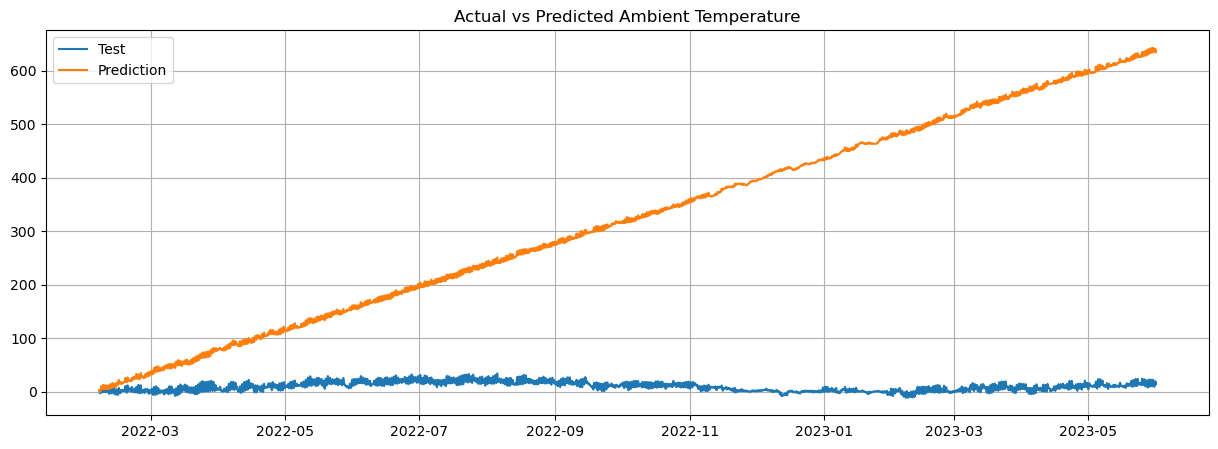

Mean Absolute Percentage Error 3514484856693602.5
Mean Squared Error 131103.58498483326
RMSE 362.0822903496293
AIC values 10439.944232720616


In [23]:

plt.figure(figsize=(15,5))
plt.grid()
#plt.plot(data['Period'][:-10], train['GDP_GROWTH'], marker='o', label='Train')
plt.plot(test['AMBIENT_TEMPERATURE'], label='Test')
plt.plot(pred, label='Prediction')
plt.legend()
plt.title('Actual vs Predicted Ambient Temperature')
plt.show()
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(test['AMBIENT_TEMPERATURE'], pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(test['AMBIENT_TEMPERATURE'], pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)
print("AIC values {}".format(arima.aic()))
print("="*50)
print("="*50)
print("="*50)
print("="*50)


In [24]:
a=pd.DataFrame(test['AMBIENT_TEMPERATURE'])
a=a.reset_index()
a=a.drop(columns='index')
a

prediction=pd.DataFrame(pred)
prediction=prediction.reset_index()
prediction=prediction.drop(columns='index')
prediction
output=pd.DataFrame()
output['Test']=a['AMBIENT_TEMPERATURE']
output['Prediction']=prediction[0]
output['Difference']=output['Test']-output['Prediction']
output['% Chnage']=abs(output['Difference']/output['Test'])*100
output

KeyError: 0

In [28]:
# VAR model = Vector Auto-regression

# maybe this instead of ARIMA or both and compare?

# source: https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

# we checked before that all data is stationary so we dont have to difference it


from statsmodels.tsa.api import VAR

model = VAR(new_data)
results = model.fit(maxlags=15, ic='aic')
print(results.summary())


c:\Python\envs\geni2024\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Jun, 2024
Time:                     18:23:03
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    4.31518
Nobs:                     271493.    HQIC:                   4.29480
Log likelihood:      -3.27775e+06    FPE:                    72.7081
AIC:                      4.28645    Det(Omega_mle):         72.5097
--------------------------------------------------------------------
Results for equation AIR_PRESSURE
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.135275         0.018578            7.281           0.000
L1.AIR_PRESSURE                       1.037078         0.001927          538.095      

In [ ]:
# lets see the forecast (data is split into test and train datasets)
# fit the model to train
# compare the forecast with test
# maybe split it 3/4 train and 1/4 test? later
# first try it on ambient temperature

In [29]:
model = VAR(train)
results = model.fit(maxlags=15, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Jun, 2024
Time:                     18:23:04
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    11.2786
Nobs:                     11511.0    HQIC:                   10.9641
Log likelihood:          -175779.    FPE:                    49256.8
AIC:                      10.8048    Det(Omega_mle):         46195.5
--------------------------------------------------------------------
Results for equation AIR_PRESSURE
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 2.881110         0.342667            8.408           0.000
L1.AIR_PRESSURE                       1.544695         0.009605          160.817      

[[ 9.65125742e+02  2.50869852e+00 -8.14699353e-02  7.65267159e+01
  -5.21384378e+00  2.13273715e+02  5.73602074e-01]
 [ 9.65566930e+02  1.43471535e+00 -1.25227871e-01  8.05606681e+01
  -3.40593850e+01  2.14030805e+02  7.50057120e-01]
 [ 9.66008206e+02  5.71277527e-01 -7.59786759e-02  8.33294606e+01
  -5.43219877e+01  2.17997916e+02  7.60927318e-01]
 [ 9.66378418e+02 -2.74948878e-01 -8.55138902e-02  8.59277350e+01
  -6.38847951e+01  2.28074840e+02  8.13376786e-01]
 [ 9.66740155e+02 -9.67551682e-01 -2.76463298e-02  8.78492422e+01
  -5.65041354e+01  2.43117943e+02  9.59589586e-01]
 [ 9.66992786e+02 -1.40175237e+00 -1.35933149e-02  8.87570956e+01
  -4.17690375e+01  2.51909963e+02  1.04876866e+00]
 [ 9.67112323e+02 -1.78568173e+00 -6.26801744e-02  8.91365415e+01
  -3.22449890e+01  2.62267549e+02  1.12182667e+00]
 [ 9.67156735e+02 -2.06633891e+00 -4.11560729e-02  8.93160400e+01
  -2.66609264e+01  2.68351004e+02  1.12664241e+00]
 [ 9.67168651e+02 -2.29525505e+00  1.22963485e-02  8.96744019e+0

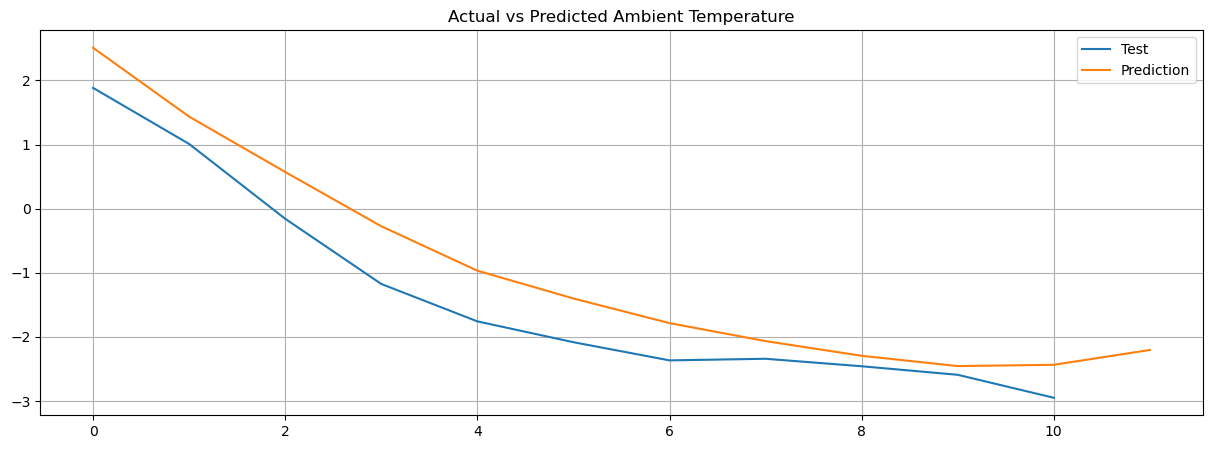

In [30]:
# AMBIENT TEMPERATURE

train_temp = train['AMBIENT_TEMPERATURE']
test_temp = test['AMBIENT_TEMPERATURE']
#print(len(train_temp)) # 11526

lagged_values = train.values[-11526:]
pred = results.forecast(y=lagged_values, steps=12) 

print(pred)

print(test[0:11])

neki = test.reset_index(drop=True)

plt.figure(figsize=(15,5))
plt.grid()
plt.plot(neki['AMBIENT_TEMPERATURE'][:11], label='Test')
plt.plot(pred[:,1], label='Prediction')
plt.legend()
plt.title('Actual vs Predicted Ambient Temperature')
plt.show()


#df_forecast=pd.DataFrame(data=pred, index=pd.DataFrame(train.index()), columns=['AIR_PRESSURE', 'AMBIENT_TEMPERATURE','RAIN_INTENSITY', 'RELATIVE_HUMIDITY', 'SOLAR_RADIATION_INTENSITY', 'WIND_DIRECTION', 'WIND_SPEED', 'AIR_PRESSURE'])






